In [27]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import log_loss
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy  as sp
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import distance
import string
from fuzzywuzzy import fuzz
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier as RFC
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import tensorflow as tf 
tf.test.gpu_device_name() 

'/device:GPU:0'

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
d=pd.read_csv('/content/drive/My Drive/quora/train.csv')

In [8]:
d.shape

(404290, 6)

**RANDOMLY SAMPLED 100000 QUESTIONS DUE TO COMPUTATIONAL LIMITATIONS**

In [0]:
df=d.sample(n=100000)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 78607 to 373116
Data columns (total 6 columns):
id              100000 non-null int64
qid1            100000 non-null int64
qid2            100000 non-null int64
question1       100000 non-null object
question2       100000 non-null object
is_duplicate    100000 non-null int64
dtypes: int64(4), object(2)
memory usage: 5.3+ MB


In [12]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
78607,78607,36057,14298,Could time travel be a real thing? Could it be...,Is time travel possible? If yes how,1
1779,1779,3542,3543,How much does investment banker earns?,How much do investment bankers make?,1
395832,395832,304667,189928,How do I delete read notifications on Quora?,How do I delete my notifications on Quora?,1
115160,115160,187842,187843,What non-European civilizations could have rep...,Why is weapon selection critical?,0
188896,188896,287539,93239,What will happen if humans go extinct?,What would happen if humans disappeared?,1


In [13]:
df['is_duplicate'].value_counts()

0    62854
1    37146
Name: is_duplicate, dtype: int64

**OBSERVATION:<BR>
  1.There are 37146 rows which are duplicates(means boths the questions are similar to each other) out of all 100000 rows and 62854 rows are not duplicates(means both the questions are not similar to each other)**

In [14]:

qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values



Total number of  Unique Questions are: 165901

Number of unique questions that appear more than one time: 19322 (11.646704962598175%)

Max number of times a single question is repeated: 42



In [15]:
print('Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))


Question pairs are not Similar (is_duplicate = 0):
   62.85%
Question pairs are Similar (is_duplicate = 1):
   37.15%


**finding duplicates in the dataset by combining id column of both the questions and is_duplicate column**

In [16]:
pair_duplicates = df.groupby(['qid1','qid2','is_duplicate']).count().reset_index()
print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


In [33]:
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


**There are only 3 duplicate rows,since we have enough rows we can drop those rows which has null values**

In [0]:
df=df.dropna() 

In [55]:
df.shape

(100000, 6)

**Random base model:since we are using log loss as a metric we will generate the mean value of the is_duplicate column and assign it as the probability for all the points in the test set...so as to keep upper bound on the log loss for further models**

In [18]:
from sklearn.metrics import log_loss

XTRAIN, XTEST= train_test_split(df[["question1","question1","is_duplicate"]],test_size = 0.2, random_state = 0)
p = XTRAIN['is_duplicate'].mean() # Our predicted probability
print('Predicted score:', log_loss(XTEST['is_duplicate'], np.zeros_like(XTEST['is_duplicate']) + p))

Predicted score: 0.6617120908118531


**OBSERVATION:<BR>
  1.From the above log loss score(0.66) which we got from a random model by assigning the mean value of total dataset "is_duplicate" column as the probability, so as to keep the bound on the future models that we develop.Any model that we use should get a log loss which is lesser than 0.66 **

**CLEANING:<BR>
  1.Removing punctuations.<br>
  2.Removing html tags.**

In [0]:
def clean(x):
  x=x.translate(str.maketrans('', '', string.punctuation))
  x=x.lower()
  x=BeautifulSoup(x)
  x=x.get_text()
  return x
a=[]
b=[]
for i in range(len(df)):
  a.append(clean(df.iloc[i,3]))
  b.append(clean(df.iloc[i,4]))
df['q1_clean']=a
df['q2_clean']=b

In [35]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_clean,q2_clean
883,883,1761,1762,What is the hardest thing(s) about raising chi...,What is the hardest thing(s) about raising chi...,0,what is the hardest things about raising child...,what is the hardest things about raising child...
36581,36581,15151,66685,Which is the most disgusting novel you've ever...,What is the most tragic novel you have ever read?,0,which is the most disgusting novel youve ever ...,what is the most tragic novel you have ever read
228607,228607,337718,337719,Which is the best book to read Vedas?,Which are the best books to learn Vedas?,1,which is the best book to read vedas,which are the best books to learn vedas
144399,144399,228552,31114,Should people who don't understand or care abo...,Do you think uneducated people should be allow...,1,should people who dont understand or care abou...,do you think uneducated people should be allow...
214629,214629,255226,73580,How can I find out who my husband is cheating ...,How do I know my husband is cheating on me?,0,how can i find out who my husband is cheating ...,how do i know my husband is cheating on me


In [0]:
train,test=train_test_split(df,test_size=0.2,random_state=1)

In [0]:
y = train.is_duplicate.values

train['q1_clean'] = train['q1_clean'].astype(str)
train['q2_clean'] = train['q2_clean'].astype(str)  
    
test['q1_clean']  = test['q1_clean'].astype(str)
test['q2_clean']  = test['q2_clean'].astype(str)

**By using tfidf vectorizer with max features set as 100000 and with ngram range from 1-3 converted the text present in question1 and question2**

In [38]:

tfv = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
            
# Fit TFIDF
tfv.fit(pd.concat([train['q1_clean'],train['q2_clean']]))
   
tr1 = tfv.transform(train['q1_clean']) 
tr2 = tfv.transform(train['q2_clean'])
    
ts1 = tfv.transform(test['q1_clean']) 
ts2 = tfv.transform(test['q2_clean'])

X = sp.sparse.hstack([tr1,tr2])
Z = sp.sparse.hstack([ts1,ts2])

print (X.shape)
print (Z.shape)
print (y.shape)

(80000, 200000)
(20000, 200000)
(80000,)


In [99]:
clf = SGDClassifier(alpha=0.00001, penalty='l2', loss='log', random_state=42)
clf.fit(X, y)
predict_y = clf.predict_proba(Z)[:,1]
print(log_loss(test['is_duplicate'], predict_y))

0.4989460256878802


**With simple tfidf featurization and with logistic regression we got a log loss of 0.49 which significantly less than the random model<br>**

**Simple NLP features**

freq_qid1 = Frequency of qid1's<BR>
freq_qid2 = Frequency of qid2's<BR>
q1len = Length of q1<BR>
q2len = Length of q2<BR>
q1_n_words = Number of words in Question 1<BR>
q2_n_words = Number of words in Question 2<BR>
word_Common = (Number of common unique words in Question 1 and Question 2)<BR>
word_Total =(Total num of words in Question 1 + Total num of words in Question 2)<BR>
word_share = (word_common)/(word_Total)<BR>
freq_q1+freq_q2 = sum total of frequency of qid1 and qid2<BR>
freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2<BR>


In [56]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['q1_clean'].str.len() 
df['q2len'] = df['q2_clean'].str.len()
df['q1_n_words'] = df['q1_clean'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['q2_clean'].apply(lambda row: len(row.split(" ")))

def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['q1_clean'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['q2_clean'].split(" ")))    
    return 1.0 * len(w1 & w2)
df['word_Common'] = df.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['q1_clean'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['q2_clean'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['q1_clean'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['q2_clean'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_clean,q2_clean,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
883,883,1761,1762,What is the hardest thing(s) about raising chi...,What is the hardest thing(s) about raising chi...,0,what is the hardest things about raising child...,what is the hardest things about raising child...,1,1,60,59,10,10,9.0,20.0,0.450000,2,0,94,87,91,92,0.883333
36581,36581,15151,66685,Which is the most disgusting novel you've ever...,What is the most tragic novel you have ever read?,0,which is the most disgusting novel youve ever ...,what is the most tragic novel you have ever read,2,1,50,48,9,10,6.0,19.0,0.315789,3,1,73,69,78,80,0.265306
228607,228607,337718,337719,Which is the best book to read Vedas?,Which are the best books to learn Vedas?,1,which is the best book to read vedas,which are the best books to learn vedas,1,1,36,39,8,8,5.0,16.0,0.312500,2,0,85,85,85,81,0.378378
144399,144399,228552,31114,Should people who don't understand or care abo...,Do you think uneducated people should be allow...,1,should people who dont understand or care abou...,do you think uneducated people should be allow...,1,1,81,56,14,10,6.0,24.0,0.250000,2,0,73,63,48,55,0.333333
214629,214629,255226,73580,How can I find out who my husband is cheating ...,How do I know my husband is cheating on me?,0,how can i find out who my husband is cheating ...,how do i know my husband is cheating on me,1,2,50,42,11,10,6.0,21.0,0.285714,3,1,80,70,74,71,0.558140


**WE WILL DO SOME ANALYSIS ON THE EXTRACTED FEATURES LIKE WILL THEY BE USEFULL FOR OUR CLASSIFICATION**

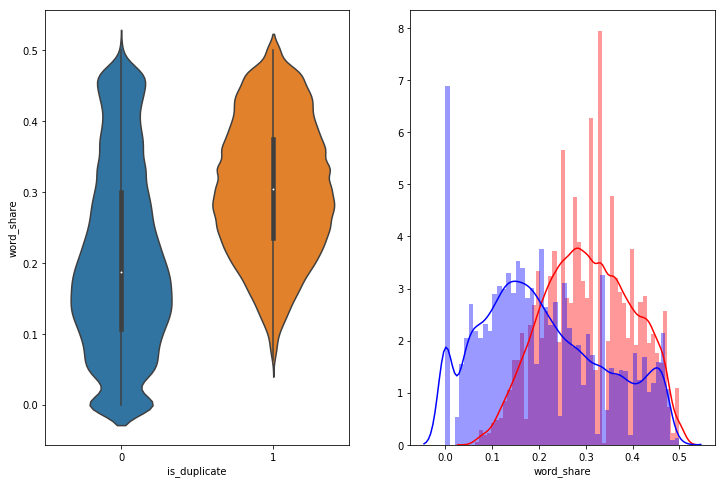

In [57]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

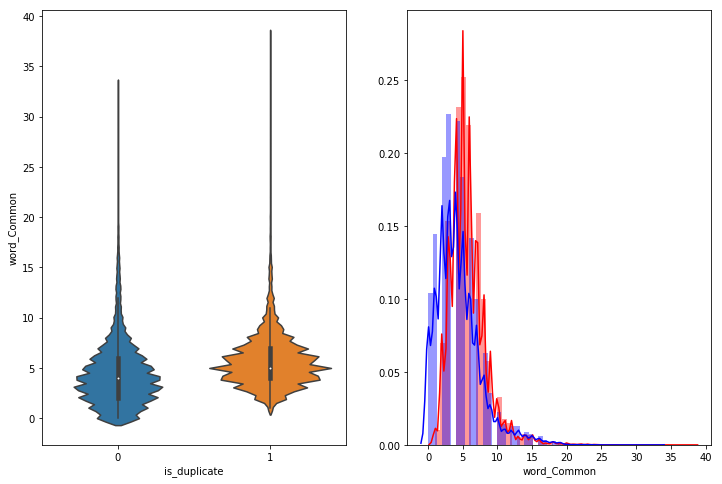

In [58]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

**FROM THE ABOVE PLOTS IT IS OBSERVED THAT THE FEATURE WORD_SHARE HAS MORE EFFECT ON OUR CLASSIFICATION THAN THE WORD_COMMON FEATURE**

**WITH THE HELP OF FUZZYWUZZY WE WILL EXTRACT SOME ADVANCE FEATURES WHICH MIGHT HELP IN OUR CLASSIFICATION**

In [0]:

# get the Longest Common sub string
#longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
#longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    print("fuzzy features..")
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["q1_clean"], x["q2_clean"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["q1_clean"], x["q2_clean"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["q1_clean"], x["q2_clean"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["q1_clean"], x["q2_clean"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["q1_clean"], x["q2_clean"]), axis=1)
    return df


In [43]:
new_df=extract_features(df)

fuzzy features..


In [44]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_clean,q2_clean,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
883,883,1761,1762,What is the hardest thing(s) about raising chi...,What is the hardest thing(s) about raising chi...,0,what is the hardest things about raising child...,what is the hardest things about raising child...,1,1,63,62,10,10,9.0,20.0,0.450000,2,0,94,87,91,92,0.883333
36581,36581,15151,66685,Which is the most disgusting novel you've ever...,What is the most tragic novel you have ever read?,0,which is the most disgusting novel youve ever ...,what is the most tragic novel you have ever read,2,1,52,49,9,10,6.0,19.0,0.315789,3,1,73,69,78,80,0.265306
228607,228607,337718,337719,Which is the best book to read Vedas?,Which are the best books to learn Vedas?,1,which is the best book to read vedas,which are the best books to learn vedas,1,1,37,40,8,8,5.0,16.0,0.312500,2,0,85,85,85,81,0.378378
144399,144399,228552,31114,Should people who don't understand or care abo...,Do you think uneducated people should be allow...,1,should people who dont understand or care abou...,do you think uneducated people should be allow...,1,1,83,57,14,10,6.0,24.0,0.250000,2,0,73,63,48,55,0.333333
214629,214629,255226,73580,How can I find out who my husband is cheating ...,How do I know my husband is cheating on me?,0,how can i find out who my husband is cheating ...,how do i know my husband is cheating on me,1,2,51,43,11,10,6.0,21.0,0.285714,3,1,80,70,74,71,0.558140


In [45]:
new_df.shape

(100000, 24)

In [0]:
new_df.to_csv('/content/drive/My Drive/quora/temp1.csv')
df1=pd.read_csv('/content/drive/My Drive/quora/temp1.csv')

**ANALYSIS ON THE ADVANCED NLP FEATURES THAT WE GOT WITH THE HELP OF FUZZYWUZZY**

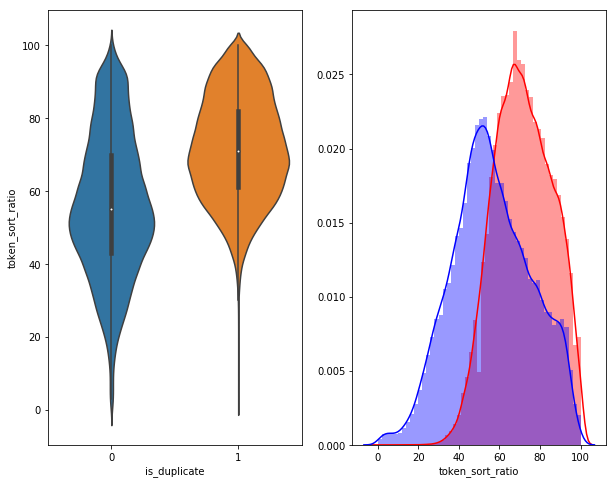

In [124]:


# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df1[0:] , )

plt.subplot(1,2,2)
sns.distplot(df1[df1['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df1[df1['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()



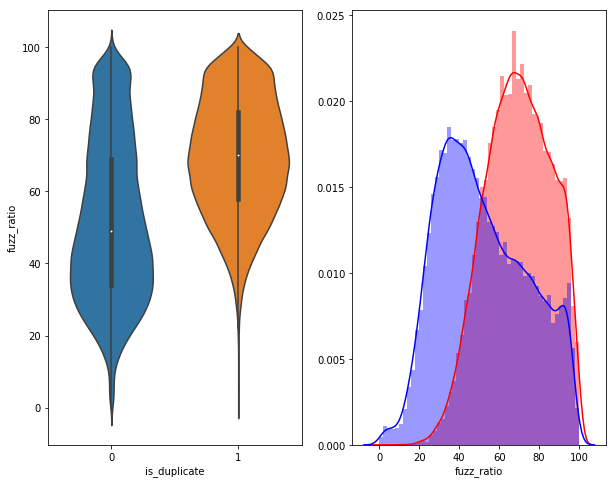

In [125]:


plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df1[0:] , )

plt.subplot(1,2,2)
sns.distplot(df1[df1['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df1[df1['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()



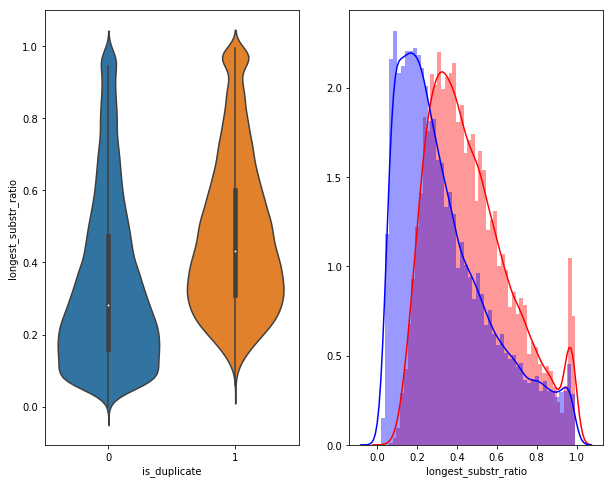

In [126]:


plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'longest_substr_ratio', data = df1[0:] , )

plt.subplot(1,2,2)
sns.distplot(df1[df1['is_duplicate'] == 1.0]['longest_substr_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df1[df1['is_duplicate'] == 0.0]['longest_substr_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()



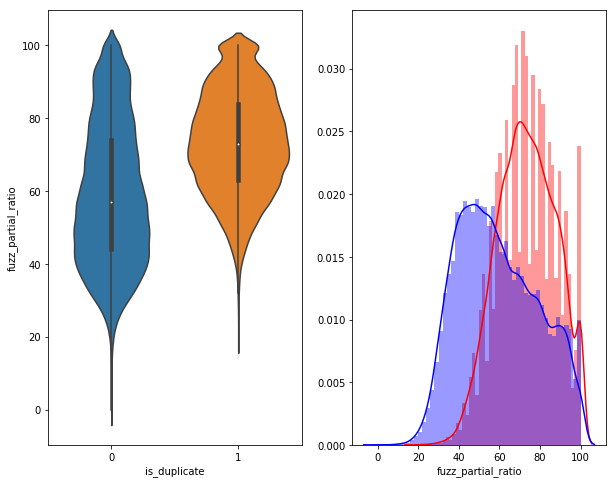

In [127]:


plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_partial_ratio', data = df1[0:] , )

plt.subplot(1,2,2)
sns.distplot(df1[df1['is_duplicate'] == 1.0]['fuzz_partial_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df1[df1['is_duplicate'] == 0.0]['fuzz_partial_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()



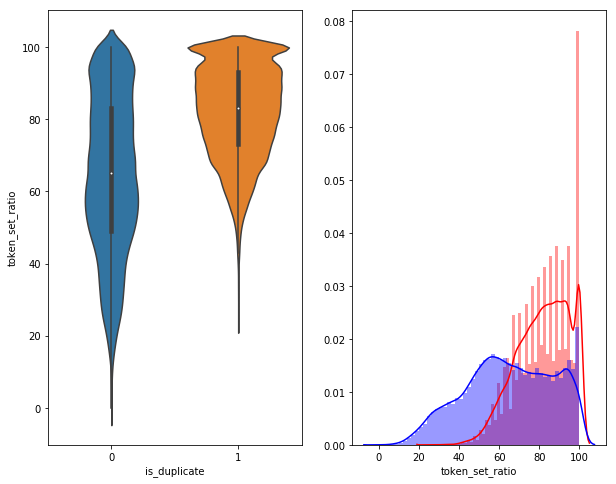

In [129]:


plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_set_ratio', data = df1[0:] , )

plt.subplot(1,2,2)
sns.distplot(df1[df1['is_duplicate'] == 1.0]['token_set_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df1[df1['is_duplicate'] == 0.0]['token_set_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()



**FROM THE ABOVE PLOTS WE CAN SEE THAT ALL THE EXTRACTED FEATURES MIGHT BE USEFULL FOR OUR CLASSIFICATION**

In [48]:
df1.columns

Index(['Unnamed: 0', 'id', 'qid1', 'qid2', 'question1', 'question2',
       'is_duplicate', 'q1_clean', 'q2_clean', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [0]:
Train,Test=train_test_split(df1,test_size=0.2,random_state=1)
Y = Train.is_duplicate.values

Train['q1_clean'] = Train['q1_clean'].astype(str)
Train['q2_clean'] = Train['q2_clean'].astype(str)  
    
Test['q1_clean']  = Test['q1_clean'].astype(str)
Test['q2_clean']  = Test['q2_clean'].astype(str)

tfidf = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
            
# Fit TFIDF
tfidf.fit(pd.concat([train['q1_clean'],train['q2_clean']]))
   
Tr1 = tfidf.transform(Train['q1_clean']) 
Tr2 = tfidf.transform(Train['q2_clean'])
    
Ts1 = tfidf.transform(Test['q1_clean']) 
Ts2 = tfidf.transform(Test['q2_clean'])


In [0]:
obj=MinMaxScaler()
X1 = obj.fit_transform(Train[['word_share','token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
X2 = obj.transform(Test[['word_share','token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])


**WE WILL NORMALISE THE EXTRACTED FEATURES AND WILL COMBINE THEM IT WITH THE FEATURES THAT WE GOT TFIDF**

In [0]:
X = sp.sparse.hstack([tr1,tr2,X1])
Z = sp.sparse.hstack([ts1,ts2,X2])

In [52]:
print(X.shape)
print(Z.shape)
print(Y.shape)

(80000, 200006)
(20000, 200006)
(80000,)


In [53]:
clf1 = SGDClassifier(alpha=0.00001, penalty='l2', loss='log', random_state=42)
clf1.fit(X, Y)
predict_y = clf1.predict_proba(Z)[:,1]
print(log_loss(Test['is_duplicate'], predict_y))

0.4088208426713765


In [54]:
import joblib
joblib.dump(clf1,'model.pkl')
joblib.dump(obj,'scaler.pkl')
joblib.dump(tfidf,'tfidf_text.pkl')

['tfidf_text.pkl']

**NOW WITH THE HELP OF THOSE FEATURES THE LOG LOSS HAS BEEN REDUCED TO 0.40**

In [157]:


estimators = [100,200,300,400,500]
test_scores = []
train_scores = []
for i in estimators:
    clf = RFC(n_estimators=i,n_jobs=-1)
    clf.fit(X,Y)
    predict_y = clf.predict_proba(X)
    log_loss_train = log_loss(Train['is_duplicate'], predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(Z)
    log_loss_test = log_loss(Test['is_duplicate'], predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('estimators = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)



estimators =  100 Train Log Loss  0.11700721508931851 Test Log Loss  0.4095386952900978
estimators =  200 Train Log Loss  0.11743745171683947 Test Log Loss  0.40916348802330627
estimators =  300 Train Log Loss  0.11694148876659778 Test Log Loss  0.4083562017692736
estimators =  400 Train Log Loss  0.11719192991786354 Test Log Loss  0.409102389468504
estimators =  500 Train Log Loss  0.11692077454805473 Test Log Loss  0.4083304598629466
